In [1]:
# Explorative Questions
    # 1. What is the time period that the dataset covers?
    # 2. What is the overall revenue for that time?
    # 3. Are there seasonal patterns in the evolution of sales?
    # 4. What are the most sold products?
    # 5. What are the products that generate the most revenue?

In [2]:
# Business Questions
  # a How should products be classified into different categories to simplify reports and analysis?
  # b What is the distribution of product prices across different categories?
  # c How many products are being discounted?
  # d How big are the offered discounts as a percentage of the product prices? how can we separate that from shipping price?
  # e How do seasonality and special dates (Christmas, Black Friday) affect sales?
  # f How could data collection be improved?

In [3]:
import pandas as pd
import fastparquet as fp
import seaborn as sns
import os
import matplotlib.pyplot as plt
import math

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 20)

In [ ]:
sns.set_style("white")
#sns.set_style("dark")

In [6]:
# load data
orders = pd.read_csv("orders_qu.csv")
orderlines = pd.read_parquet("orderlines_qu.parquet")
products = pd.read_parquet("products_qu.parquet")
brands = pd.read_csv("brands.csv")

In [15]:
### ---------- EXPLORATIVE QUESTIONS ---------- ### 

In [16]:
# 1. What is the time period that the dataset covers?
# 01.01.2017 - 14.03.2018
orders.created_date.agg(["min", "max"])

min    2017-01-01 01:51:47
max    2018-03-14 12:03:52
Name: created_date, dtype: object

In [17]:
# 2. What is the overall revenue for that time?
# 7978675.6, 7817204.4 the difference is 161471.2
# 7.9 million (as unit_price_total is the artificial column made by us)
orders.total_paid.sum(), orderlines.unit_price_total.sum()



(14871951.86, 14703886.259999996)

In [18]:
orders.total_paid.sum() - orderlines.unit_price_total.sum()

168065.60000000335

In [19]:
# 3. Are there seasonal patterns in the evolution of sales?
# highest sales in 2017 quarter 4
orders["created_date"] = pd.to_datetime(orders["created_date"])
orders["quarter"] = orders.created_date.dt.quarter
orders["year"] = orders.created_date.dt.year
orders.groupby(["year", "quarter"])["total_paid"].sum()

year  quarter
2017  1         1846288.74
      2         1613544.01
      3         2534737.66
      4         5661669.66
2018  1         3215711.79
Name: total_paid, dtype: float64

<Axes: xlabel='year,quarter'>

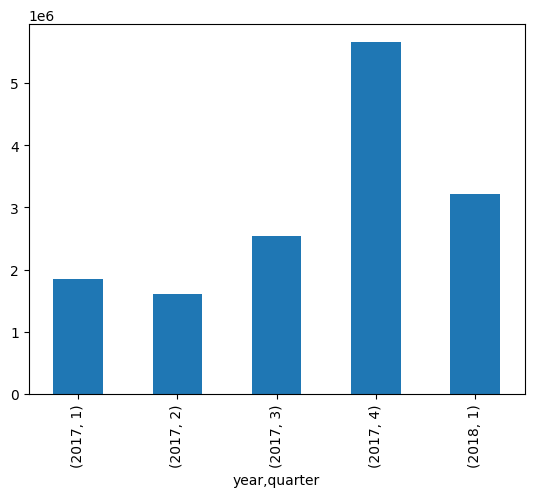

In [20]:
orders.groupby(["year", "quarter"])["total_paid"].sum().plot(kind="bar")

In [23]:
# 4. What are the most sold products?
# no1: iphone protection plan, in general apple products
orderlines.merge(products, left_on="sku", right_on="sku").groupby(["sku", "name"])["product_quantity"].sum().sort_values(ascending=False)[0:10]

sku      name                                                                
APP1190  IPhone AppleCare Protection Plan                                        985
APP0698  Apple Lightning Cable Connector to USB 1m White (OEM)                   826
APP1922  AirPods Apple Bluetooth Headset for iPhone iPad iPod and Apple Watch    549
WDT0183  Red 4TB WD 35 "Mac PC hard drive and NAS                                498
APP0927  EarPods Apple Headphones with Remote and Mic (OEM)                      493
CRU0051  Crucial MX300 525GB SSD Disk                                            340
SAM0074  Samsung 850 EVO SSD Disk 500GB                                          338
APP1214  Apple Magic Mouse 2                                                     279
APP2446  Apple iPhone 6 32GB Space Gray                                          271
CRU0050  Crucial MX300 275GB SSD Disk                                            262
Name: product_quantity, dtype: int64

In [24]:
products[products["sku"]=="APP2075"]

,sku,name,desc,price,promo_price,in_stock,short_type,category,brand_short,brand
7550,APP2075,"Apple MacBook Pro 15 ""Core i7 Touch Bar 29Ghz ...",New MacBook Pro 15-inch Core i7 Touch Bar 29Gh...,3305.59,2999.00,0,1020,iPad/Mac/Tablet,APP,Apple


In [26]:
# 5. What are the products that generate the most revenue?
# no 1: LG Monitor, overall many iPhones, no 2-10 all apple products
orderlines.merge(products, left_on="sku", right_on="sku").groupby(["sku", "name"])["unit_price_total"].sum().sort_values(ascending=False)[0:10]

sku      name                                                                                                     
APP2075  Apple MacBook Pro 15 "Core i7 Touch Bar 29Ghz | RAM 16GB | 512GB PCIe SSD | 560 4GB Radeon Pro Space Gray   212411.11
APP2074  Apple MacBook Pro 15 "Core i7 Touch Bar 28GHz | RAM 16GB | 256GB PCIe SSD | 555 2GB Radeon Pro Space Gray   153884.97
LGE0044  LG 27UD88-W Monitor 27 "UHD 4K USB 3.0 USB-C                                                                139377.77
APP2489  Apple iPhone 64GB Space Gray X                                                                              130131.00
APP2072  Apple MacBook Air 13 "Core i5 18GHz | 8GB RAM | 128GB SSD                                                   129397.08
PAC2136  Apple iMac 27 "Core i5 Retina 5K 34GHz | 16GB | 1TB Fusion                                                  126672.95
APP2073  Apple MacBook Air 13 "Core i5 18GHz | 8GB RAM | 256GB SSD                                                   121385

In [ ]:
### ---------- BUSINESS QUESTIONS ---------- ### 

In [28]:
# a How should products be classified into different categories to simplify reports and analysis?

products.category.nunique() # 17 categories

18

<Axes: ylabel='Frequency'>

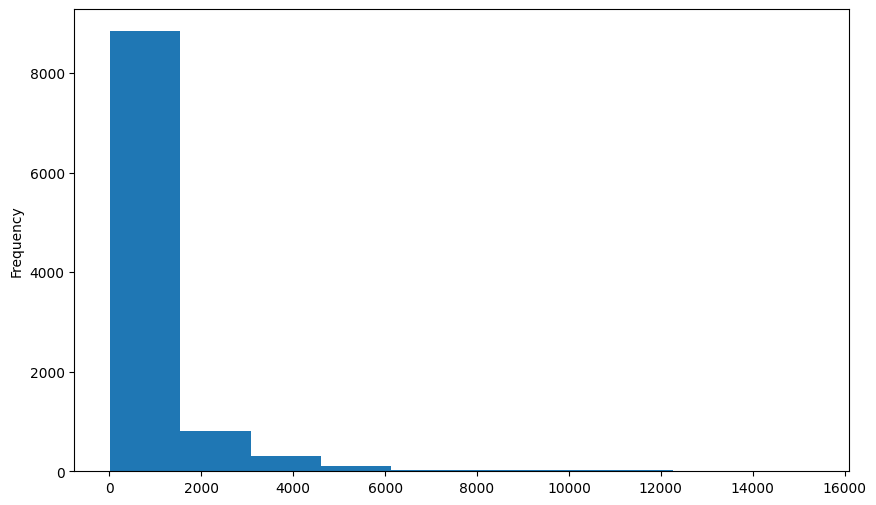

In [30]:
products["price"].plot(kind="hist", figsize=(10,6))

In [31]:
# adding price categories
products["price_category"] = "high-end"
products.loc[products["price"] <= 1000,"price_category"] = "exp"
products.loc[products["price"] <= 200,"price_category"] = "medium"
products.loc[products["price"] <= 50,"price_category"] = "low"

<Axes: xlabel='price_category'>

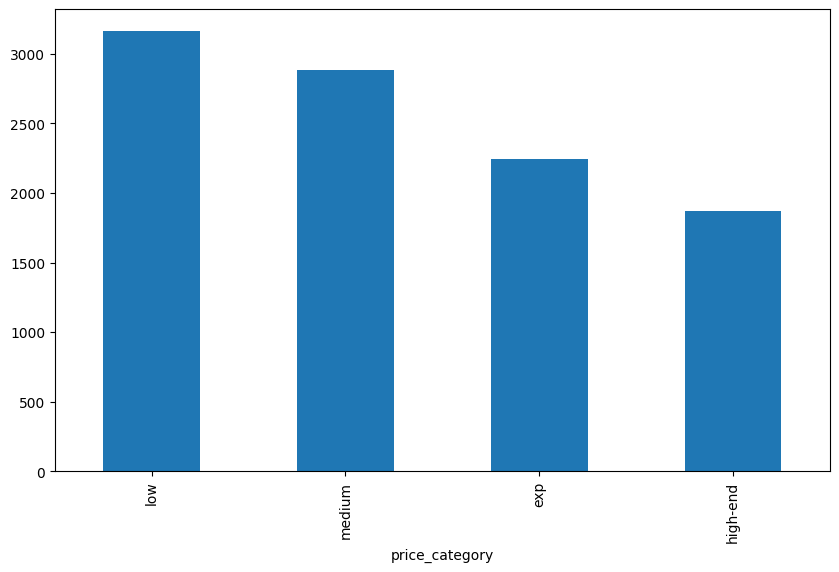

In [32]:
products["price_category"].value_counts().plot(kind="bar", figsize=(10,6))

In [33]:
# categories with highest revenue
orderlines.merge(products, left_on="sku", right_on="sku").groupby("category")["unit_price_total"].sum().sort_values(ascending=False)[0:10]

category
iPad/Mac/Tablet        6280607.94
other                  1703802.29
iPhone                 1613404.07
memory                 1541986.50
monitor                1255415.68
power                   929704.61
computer accessories    325253.74
care                    206750.47
expansion               182505.11
music                   171039.62
Name: unit_price_total, dtype: float64

In [34]:
# categories most sold
orderlines.merge(products, left_on="sku", right_on="sku").groupby("category")["product_quantity"].sum().sort_values(ascending=False)[0:10]

category
power                   13804
other                   13268
memory                   9459
iPad/Mac/Tablet          4918
care                     4420
cases                    4371
computer accessories     3802
monitor                  3239
iPhone                   2598
music                    1884
Name: product_quantity, dtype: int64

In [35]:
# b What is the distribution of product prices across different categories?
orderlines.merge(products, left_on="sku", right_on="sku").groupby("category")["unit_price"].describe().sort_values("count", ascending=False)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
power,12156.00,70.95,105.95,2.00,19.99,39.99,82.79,3157.80
other,11469.00,134.72,291.52,0.01,32.99,70.99,139.49,7335.59
memory,7684.00,174.45,266.26,3.79,59.99,111.99,192.19,8287.80
iPad/Mac/Tablet,4721.00,1303.93,1055.26,24.00,383.04,1015.99,2098.60,5917.00
cases,4178.00,32.85,29.95,2.84,16.99,29.99,40.99,1010.99
care,4098.00,47.20,68.18,5.99,16.99,26.99,54.00,906.18
computer accessories,3532.00,87.22,175.84,2.82,27.89,69.99,99.99,2763.79
monitor,2780.00,414.71,454.68,7.01,99.99,279.00,559.99,2457.99
iPhone,2527.00,618.89,253.42,25.99,381.52,570.33,799.00,1159.00


In [36]:
# visualizing the mean price per category
mean_price_per_category = pd.DataFrame(products.groupby("category")["price"].mean()).reset_index()

In [37]:
mean_price_per_category.sort_values("price", ascending=False, inplace=True)

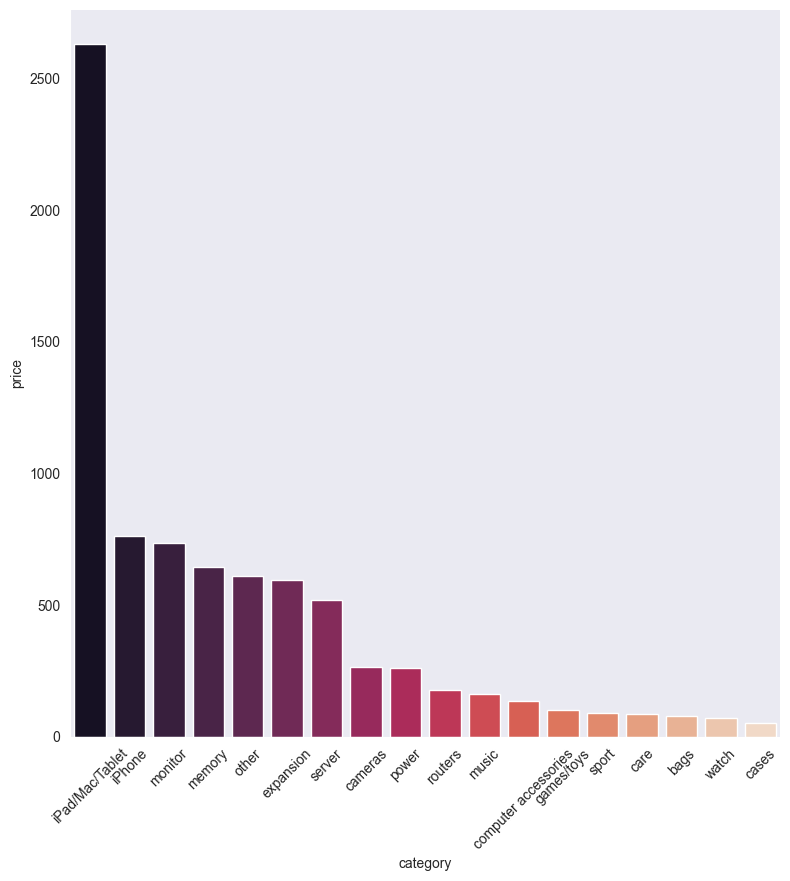

In [39]:
# in a barplot
sns.catplot(mean_price_per_category,
            kind="bar",
            x="category",
            y="price",
            palette="rocket",
            height=8);
plt.xticks(rotation=45);

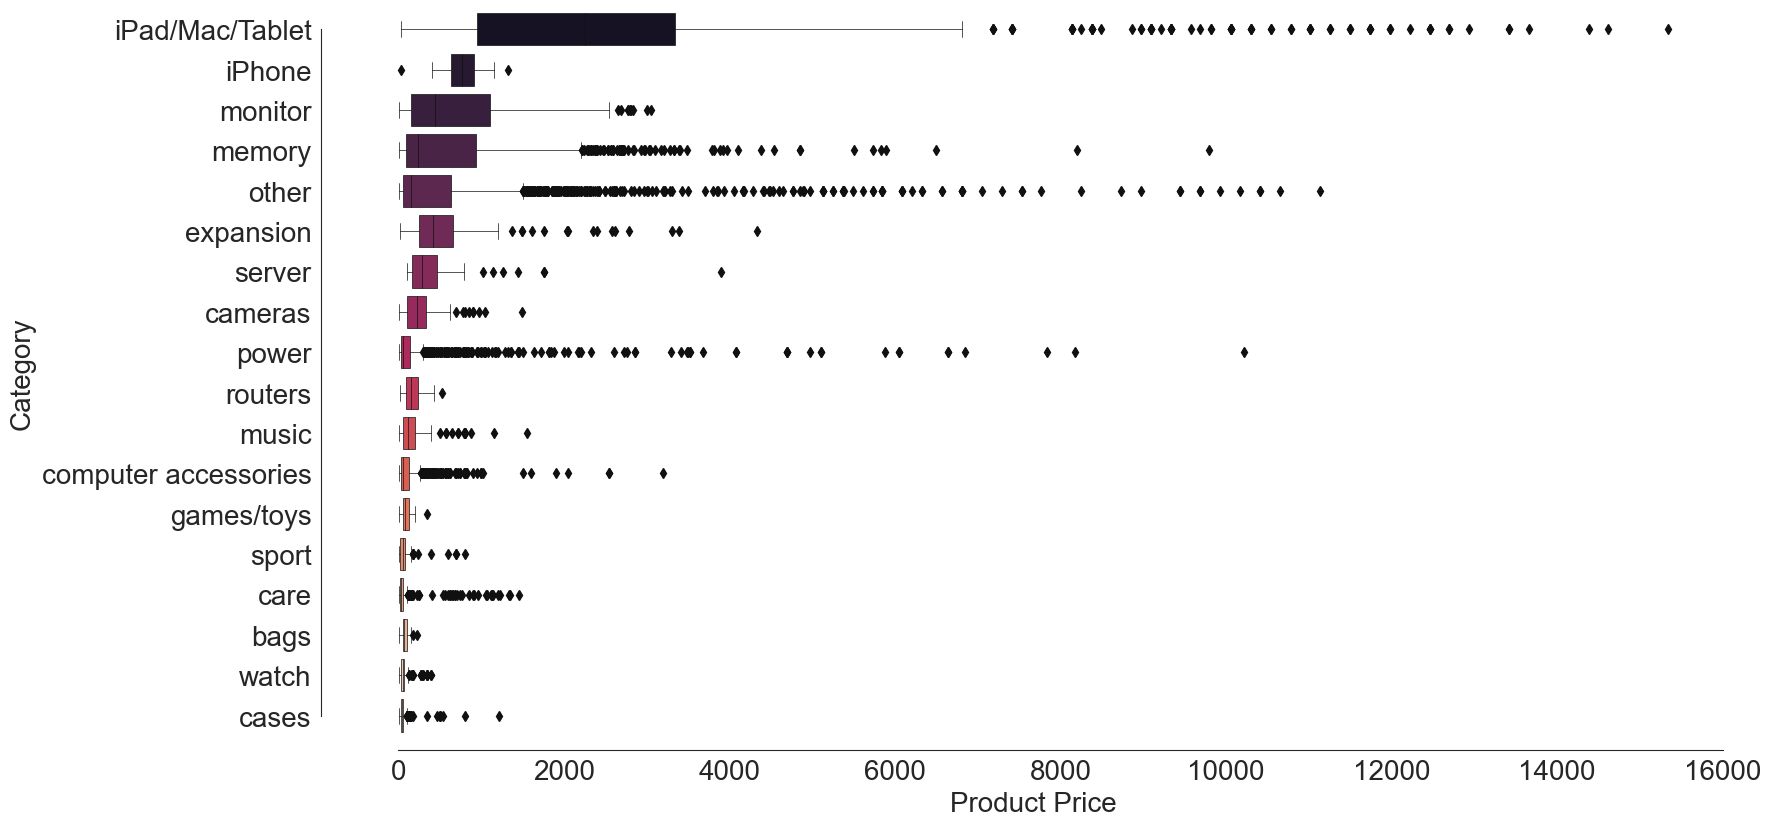

In [368]:
# in a boxplot

sorted= products.groupby("category")["price"].mean().sort_values(ascending=False).index
products.reset_index(inplace=True)

sns.catplot(products,
            kind="box",
            y="category",
            x="price",
          #  hue="category",
            palette="rocket",
            height=8,
           aspect=2,
           order=sorted,
           linewidth=0.5)
sns.despine(offset=10, trim=True)
plt.xticks(fontsize=20)
plt.xlabel("Product Price", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Category", fontsize=20);

<Axes: xlabel='category'>

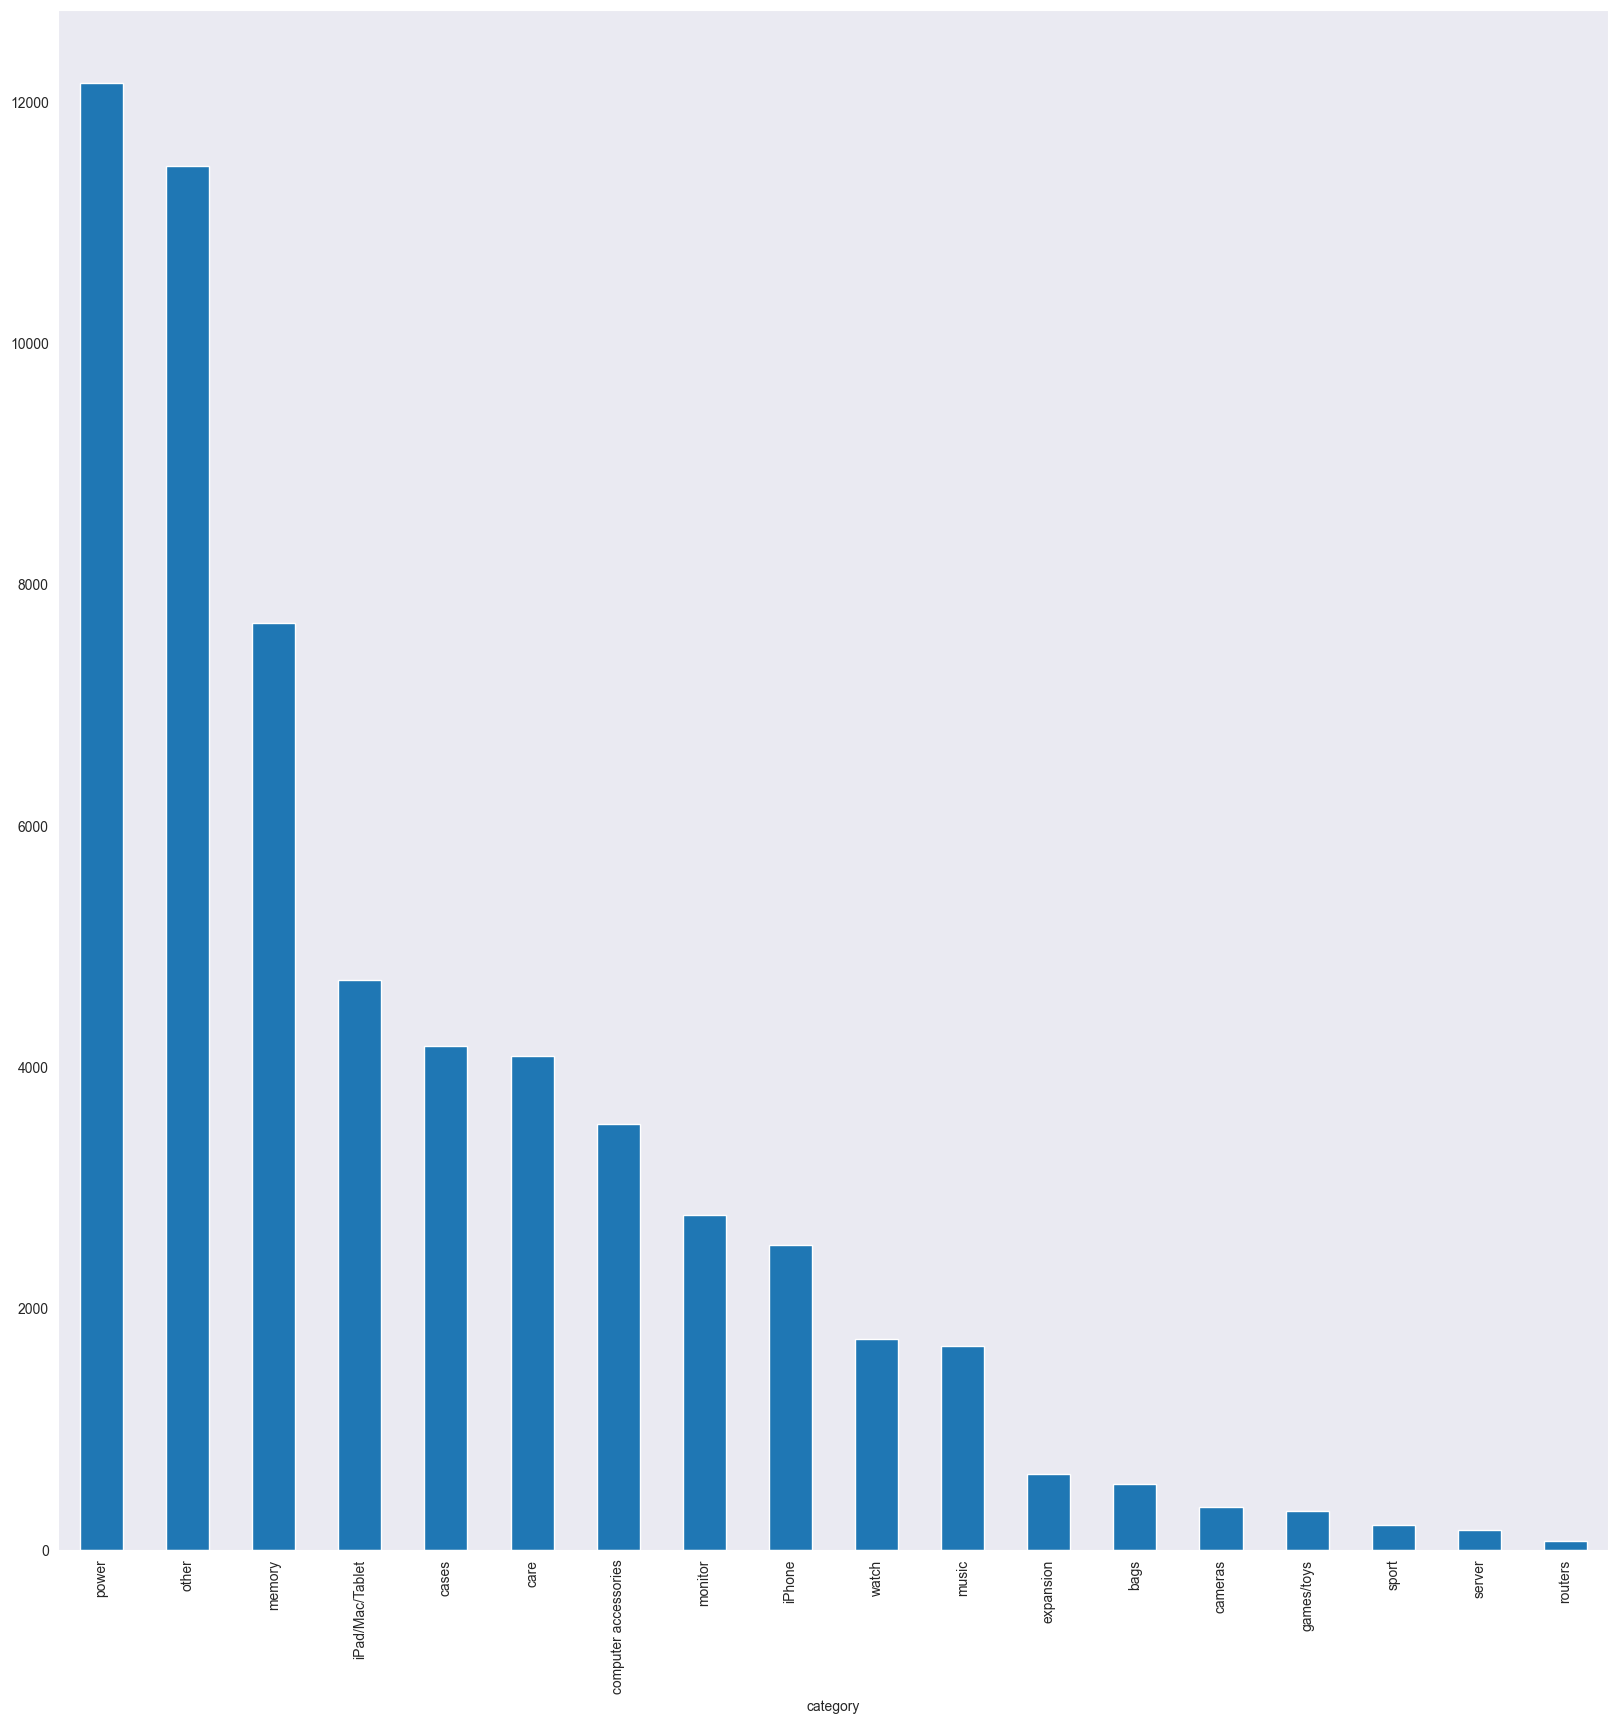

In [50]:
# plotting most sold categories
orderlines.merge(products, left_on="sku", right_on="sku").groupby("category")["unit_price"].count().sort_values(ascending=False).plot(kind="bar", figsize=(20,20))

In [52]:
# c How many products are being discounted?

In [66]:
#  5691 products are being discounted, 495 are not
orderlines.loc[orderlines["discount"]!=0, "sku"].nunique(), orderlines.loc[orderlines["discount"]==0, "sku"].nunique()

5691

In [68]:
# discounted products per category
orderlines["discounted"] = "no"

In [69]:
orderlines.loc[orderlines["discount"]!=0, "discounted"]  = "yes"

In [71]:
sold_products = products.merge(orderlines, how="inner", on="sku")

In [72]:
sold_products.head()

,index_x,sku,name_x,desc_x,price_x,promo_price_x,in_stock_x,short_type_x,category_x,brand_short_x,...,price_y,promo_price_y,in_stock_y,short_type_y,category_y,brand_short_y,brand_y,price_category_y,discount_y,discounted
0,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,49.99,1,8696,other,RAI,...,59.99,49.99,1,8696,other,RAI,Rain Design,medium,5.00,yes
1,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,49.99,1,8696,other,RAI,...,59.99,49.99,1,8696,other,RAI,Rain Design,medium,10.00,yes
2,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,49.99,1,8696,other,RAI,...,59.99,49.99,1,8696,other,RAI,Rain Design,medium,10.00,yes
3,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,49.99,1,8696,other,RAI,...,59.99,49.99,1,8696,other,RAI,Rain Design,medium,5.00,yes
4,0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,49.99,1,8696,other,RAI,...,59.99,49.99,1,8696,other,RAI,Rain Design,medium,5.00,yes


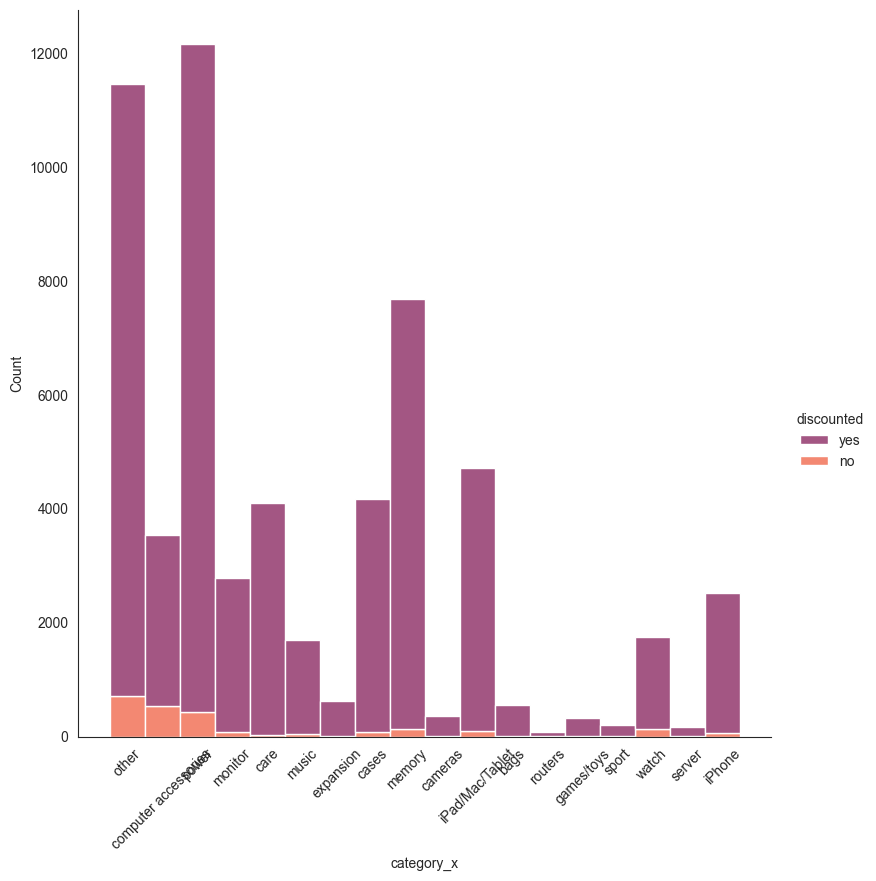

In [73]:
# plotting discounted products per category
sns.displot(data=sold_products,
            kind="hist",
           x="category_x",
            multiple="stack",
            hue="discounted",
            palette="rocket",
            element="bars", 
            #col_order=order,
            height=8
           );
plt.xticks(rotation=45) ;

In [81]:
# d How big are the offered discounts as a percentage of the product prices?

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_total,index,name,...,price,promo_price,in_stock,short_type,category,brand_short,brand,price_category,discount,discounted
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,47.49,757,OWC In-line Digital Temperature Sensor Kit HDD...,...,60.99,49.99,1,5395,other,OWC,OWC,medium,13.50,yes
1,1120182,299404,0,1,OWC0100,47.49,2017-01-01 22:50:39,47.49,757,OWC In-line Digital Temperature Sensor Kit HDD...,...,60.99,49.99,1,5395,other,OWC,OWC,medium,13.50,yes
2,1121550,300650,0,1,OWC0100,49.99,2017-01-02 15:31:09,49.99,757,OWC In-line Digital Temperature Sensor Kit HDD...,...,60.99,49.99,1,5395,other,OWC,OWC,medium,11.00,yes
3,1121801,300760,0,1,OWC0100,49.99,2017-01-02 17:20:31,49.99,757,OWC In-line Digital Temperature Sensor Kit HDD...,...,60.99,49.99,1,5395,other,OWC,OWC,medium,11.00,yes
4,1124334,301975,0,1,OWC0100,49.99,2017-01-03 20:04:54,49.99,757,OWC In-line Digital Temperature Sensor Kit HDD...,...,60.99,49.99,1,5395,other,OWC,OWC,medium,11.00,yes


In [378]:
orderlines["discount"].sum() / orderlines["price"].sum() * 100

14.609773287205035

In [379]:
# e How do seasonality and special dates (Christmas, Black Friday) affect sales?

In [85]:
orders["created_date"] = pd.to_datetime(orders["created_date"])
tp_mean = pd.DataFrame(orders.resample("D", on="created_date")["total_paid"].mean())
tp_mean.reset_index(inplace=True)
tp_mean

,created_date,total_paid
0,2017-01-01,274.36
1,2017-01-02,187.11
2,2017-01-03,199.95
3,2017-01-04,282.53
4,2017-01-05,171.70
...,...,...
433,2018-03-10,198.82
434,2018-03-11,244.76
435,2018-03-12,344.07
436,2018-03-13,248.75


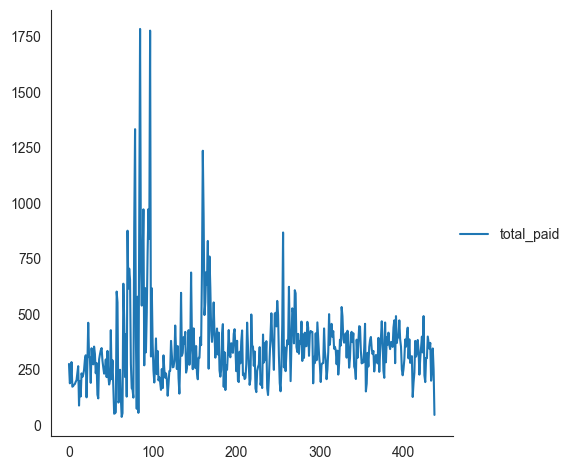

In [86]:
sns.relplot(data=tp_mean,
            kind="line");

In [87]:
orderlines["date"] = pd.to_datetime(orderlines["date"])

In [88]:
orderlines.reset_index(inplace=True)

In [89]:
ol_mean= pd.DataFrame(orderlines.groupby("discounted").resample("D", on="date")["unit_price_total"].sum()) # throws an error with index. dropping it helps


In [90]:
ol_mean.reset_index(inplace=True)
ol_mean

,discounted,date,unit_price_total
0,no,2017-01-01,591.99
1,no,2017-01-02,2678.70
2,no,2017-01-03,2919.72
3,no,2017-01-04,374.93
4,no,2017-01-05,287.93
...,...,...,...
870,yes,2018-03-10,11946.06
871,yes,2018-03-11,15640.38
872,yes,2018-03-12,46058.24
873,yes,2018-03-13,17089.78


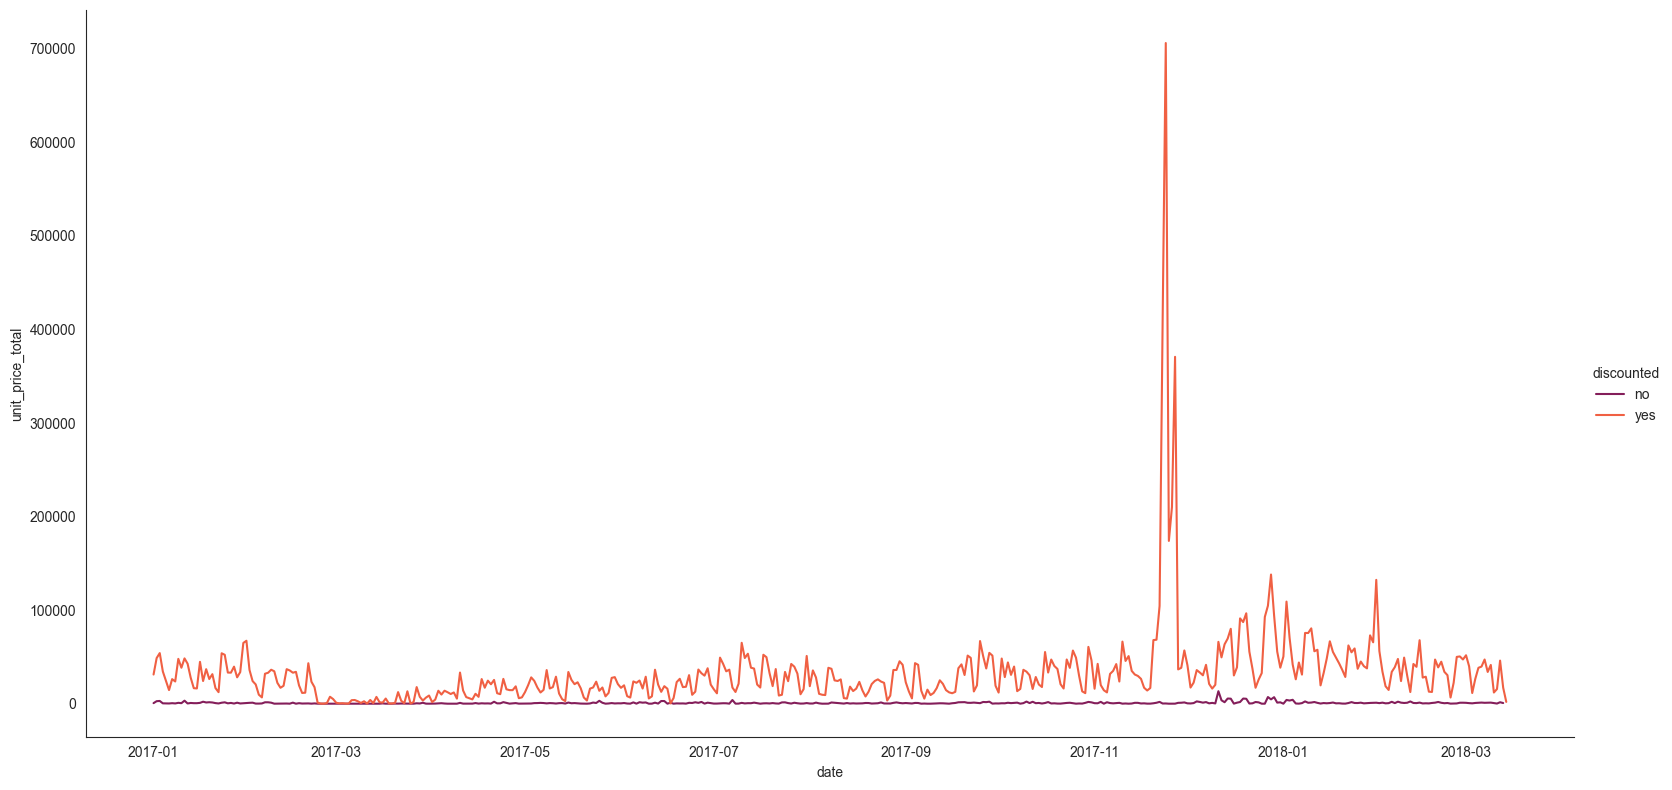

In [91]:
# plotting sales of discounted and non-discounted products
sns.relplot(data=ol_mean,
            kind="line",
             x="date",
             y="unit_price_total",
             hue="discounted",
             palette="rocket",
            height=8,
            aspect=2
           );

In [105]:
# looking into a specific time frame
start = pd.to_datetime("2017-11")
end=pd.to_datetime("2018-02")
mean_daily_discounted.set_index("date", inplace=True)
mean_daily_discounted_11_01 = mean_daily_discounted[start:end]

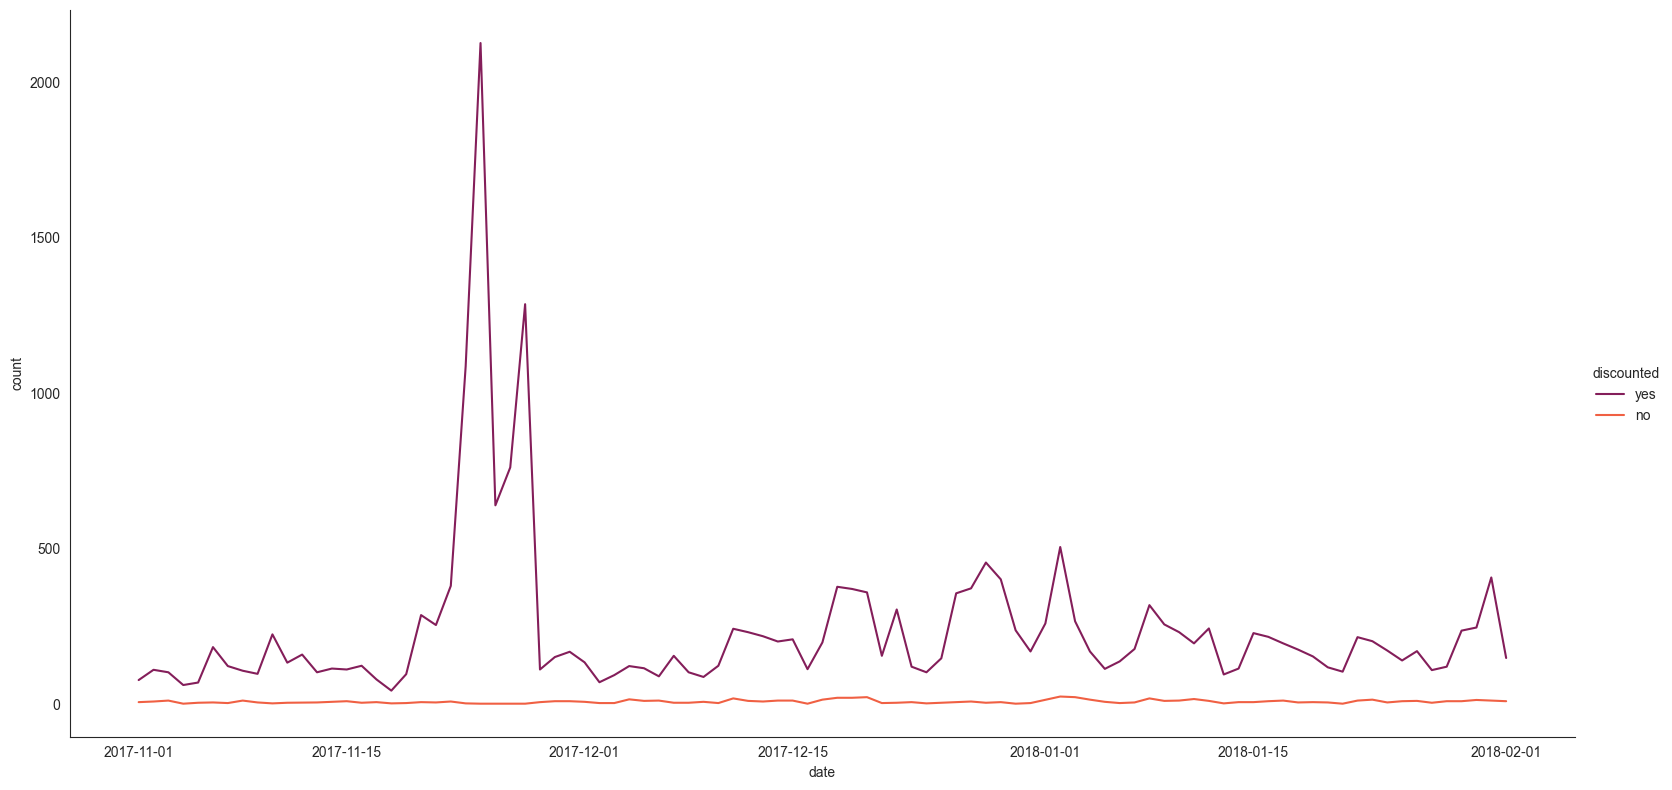

In [106]:
sns.relplot(data=mean_daily_discounted_11_01,
            kind="line",
             x="date",
             y="count",
             palette="rocket",
            hue="discounted",
            height=8,
            aspect=2
           );


In [112]:
# what are the differnces in sales in time?
cat_sold_per_day = orderlines.merge(products, on="sku").groupby("category_y").resample("D", on="date")["sku"].count()

In [113]:
cat_sold_per_day = cat_sold_per_day.reset_index()

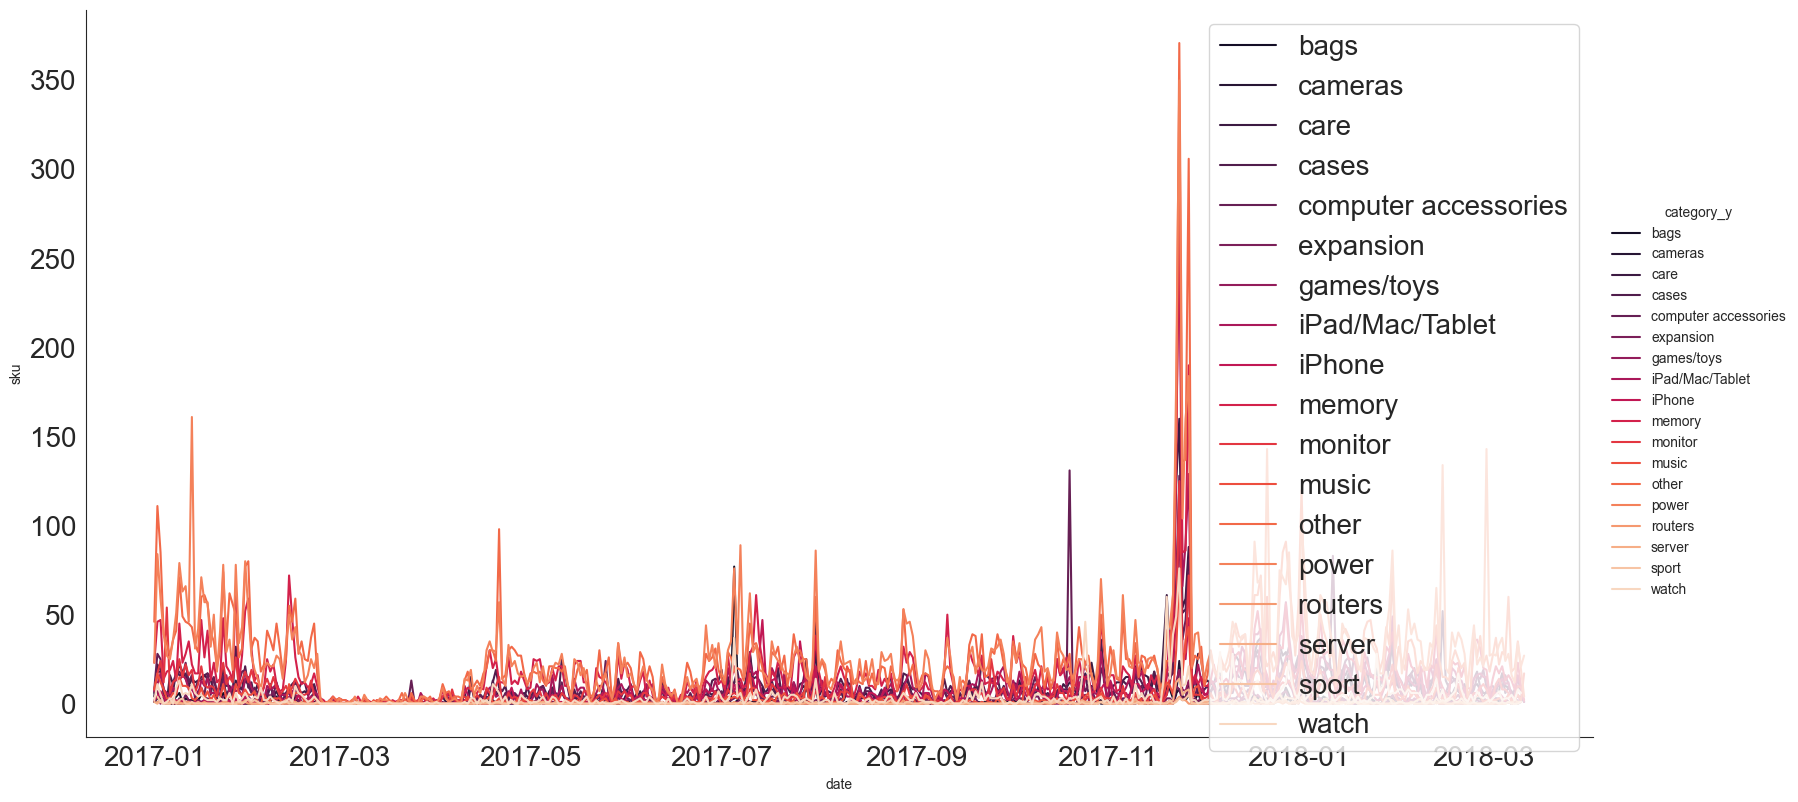

In [116]:
# plotting categories sales through timeframe
sns.relplot(data=cat_sold_per_day,
            kind="line",
             x="date",
             y="sku",
             palette="rocket",
            hue="category_y",
            height=8,
            aspect=2
           )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [386]:
# looking into two examples: cases + iPhones
iphone_cases = cat_sold_per_day[cat_sold_per_day["category_y"].isin(["cases", "iPhone"])]

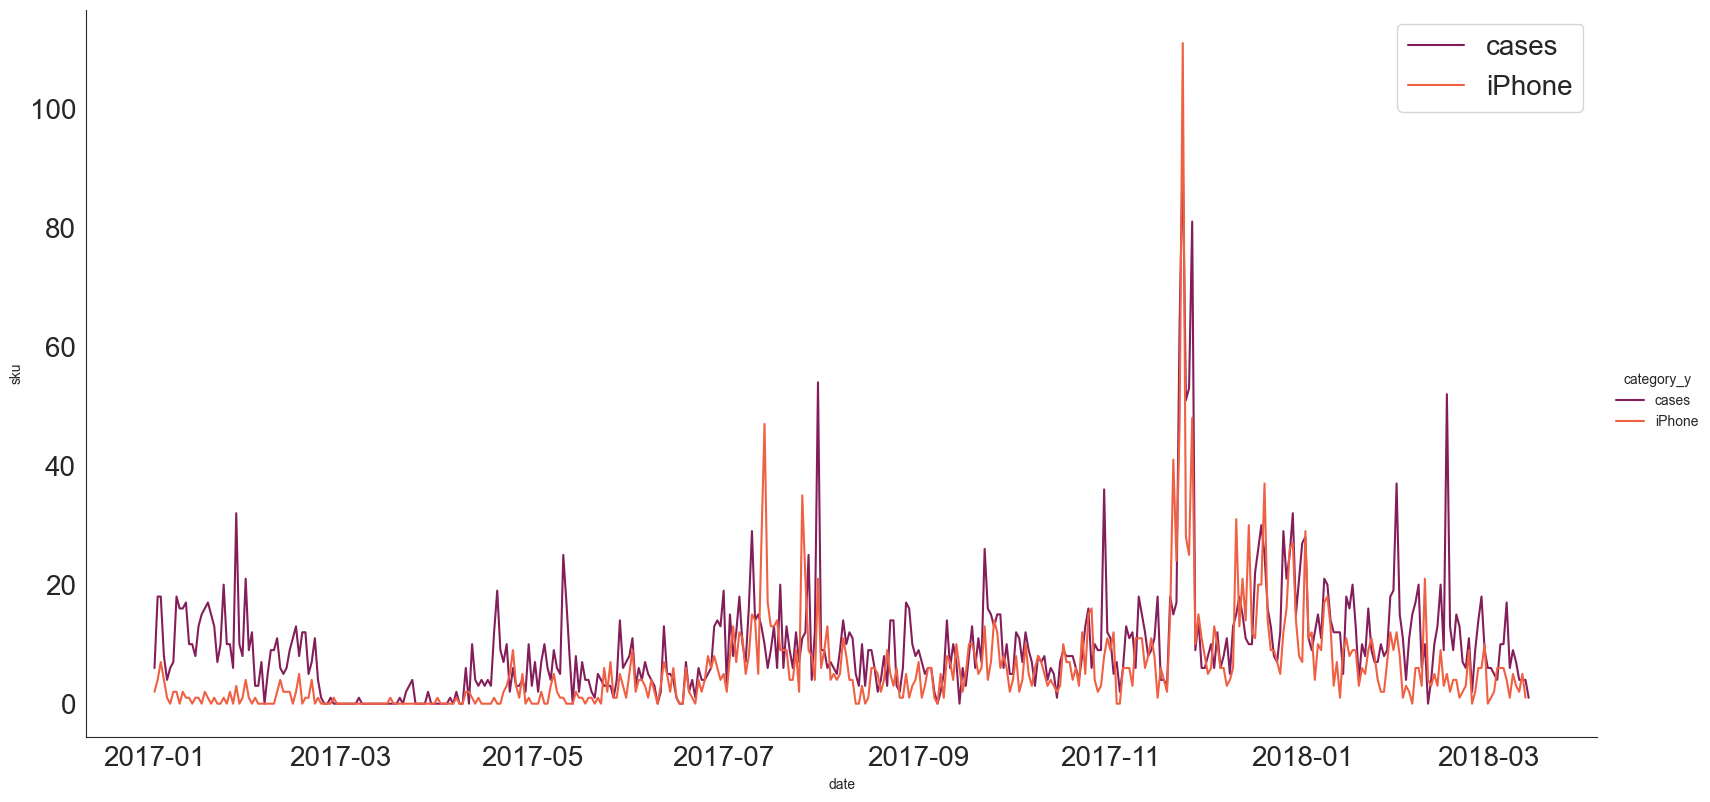

In [121]:
sns.relplot(data=iphone_cases,
            kind="line",
             x="date",
             y="sku",
             palette="rocket",
            hue="category_y",
            height=8,
            aspect=2
           )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [122]:
# most sold products on black friday
orderlines.resample("D", on="date")["sku"].count()

date
2017-01-01    140
2017-01-02    389
2017-01-03    330
2017-01-04    149
2017-01-05    157
             ... 
2018-03-10     80
2018-03-11     74
2018-03-12    169
2018-03-13     98
2018-03-14     53
Freq: D, Name: sku, Length: 438, dtype: int64

In [126]:
sold_categories_black = orderlines[orderlines.date.dt.strftime('%Y-%m-%d') == "2017-11-24"].merge(products, on="sku").groupby("category_y")["sku"].count().sort_values(ascending=False)

In [127]:
sold_categories_black = pd.DataFrame(sold_categories_black).reset_index()

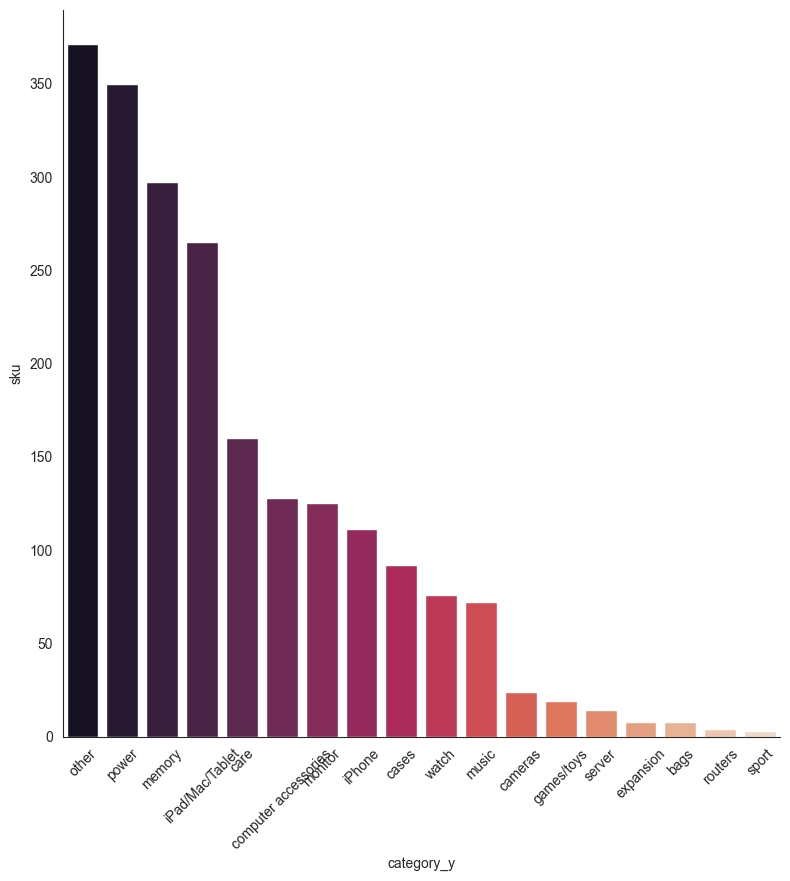

In [128]:
sns.catplot(sold_categories_black,
            kind="bar",
            x="category_y",
            y="sku",
            palette="rocket",
            height=8);
plt.xticks(rotation=45);

In [130]:
# plot price_cat over time
price_cat_over_time = products.merge(orderlines, on="sku").groupby("price_category_y").resample("D", on="date")["sku"].count().reset_index()

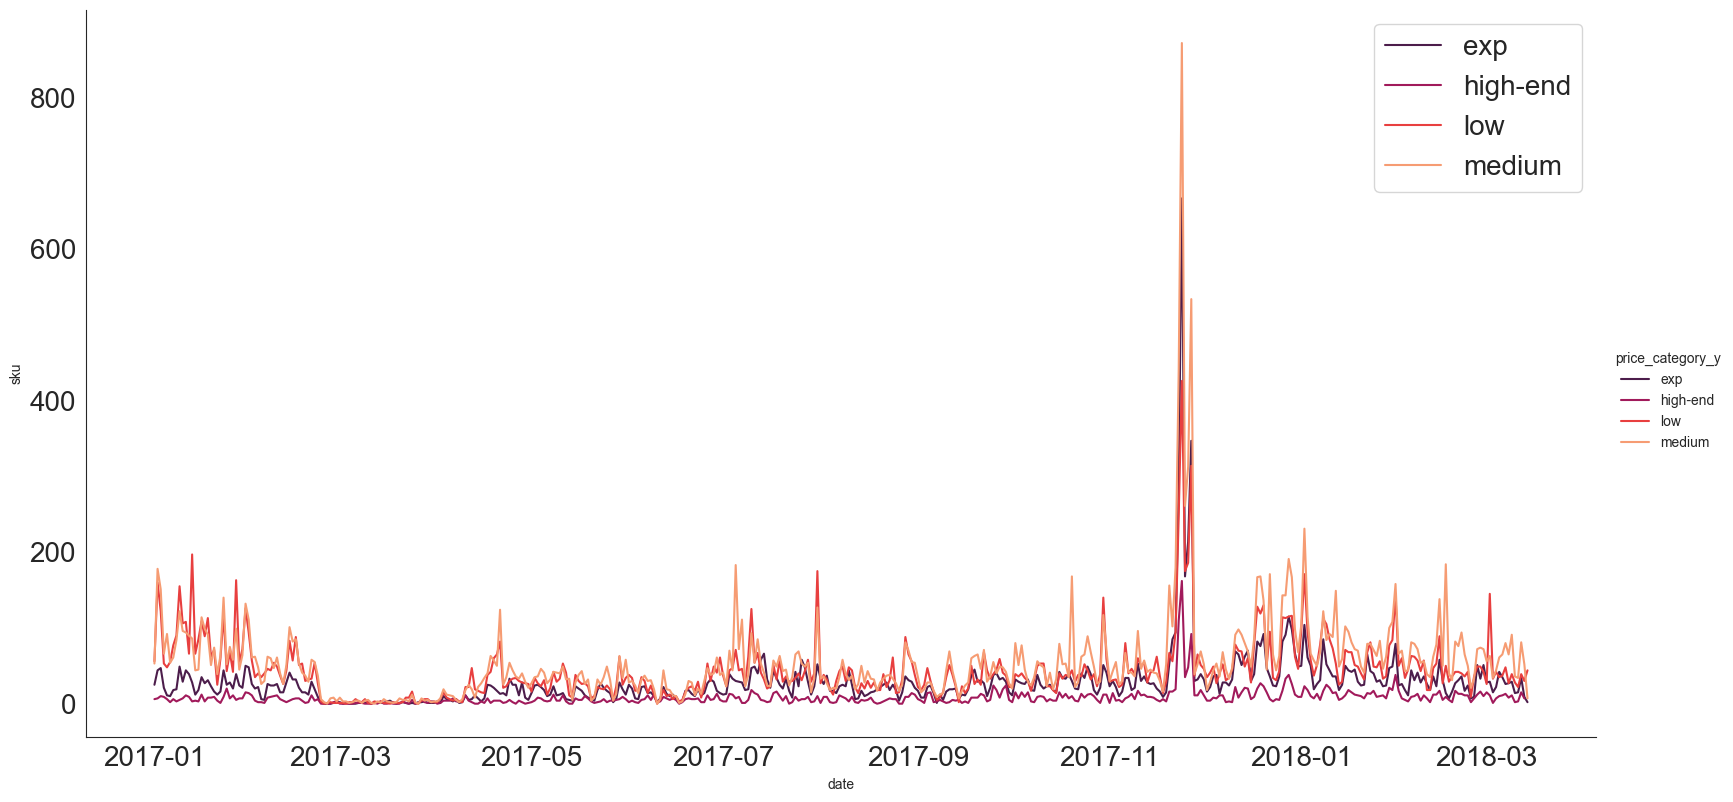

In [132]:
sns.relplot(price_cat_over_time,
            kind="line",
             x="date",
             y="sku",
             palette="rocket",
            hue="price_category_y",
            height=8,
            aspect=2
           )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20);

In [149]:
# overall most sold categories
most_sold_cats = orderlines.merge(products, on="sku").groupby("category_y").agg({"sku": "count", "unit_price_total":"sum"}).sort_values(ascending=False, by="sku")

In [150]:
most_sold_cats = pd.DataFrame(most_sold_cats).reset_index()

In [151]:
most_sold_cats

,category_y,sku,unit_price_total
0,power,12156,929704.61
1,other,11469,1703802.29
2,memory,7684,1541986.50
3,iPad/Mac/Tablet,4721,6280607.94
4,cases,4178,141904.90
5,care,4098,206750.47
6,computer accessories,3532,325253.74
7,monitor,2780,1255415.68
8,iPhone,2527,1613404.07
9,watch,1745,158631.88


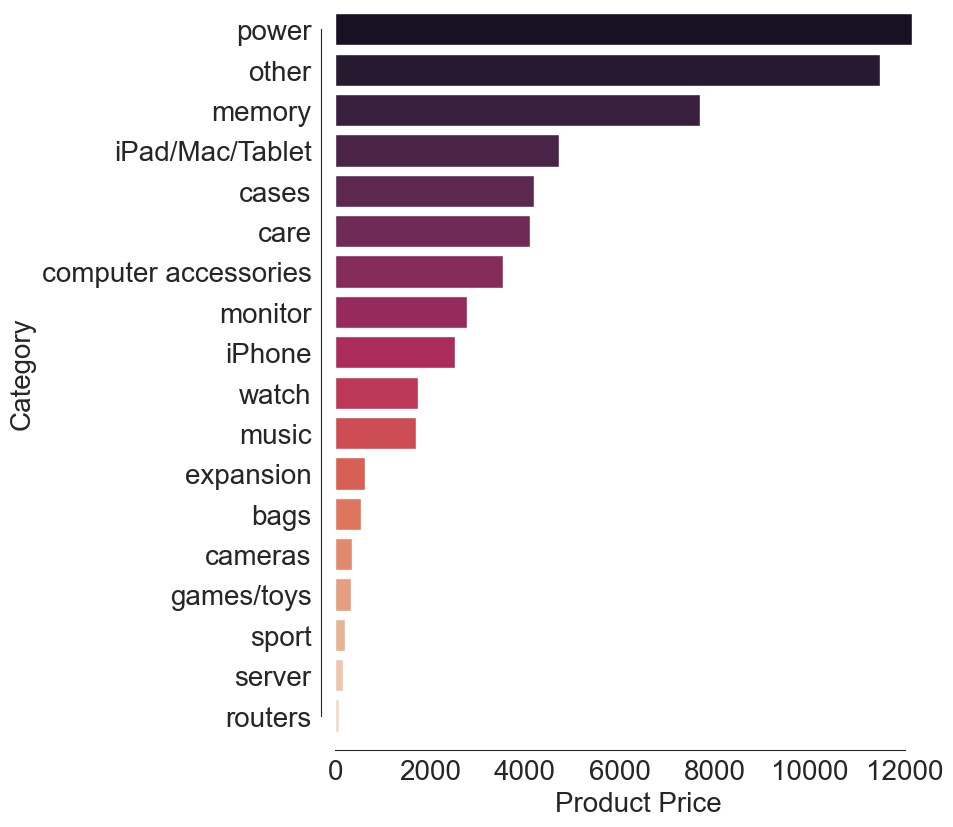

In [157]:
sns.catplot(most_sold_cats,
            kind="bar",
            x="sku",
            y="category_y",
            palette="rocket",
            height=8);
sns.despine(offset=10, trim=True)
plt.xticks(fontsize=20)
plt.xlabel("Product Price", fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Category", fontsize=20);

In [283]:
# how is the differences in discounted and non discounted products within price categories?
sales_price_cat = products.merge(orderlines, on="sku").groupby(["price_category_y", "discounted"])["unit_price_total"].sum()

In [284]:
sales_price_cat = sales_price_cat.reset_index().set_index("price_category_y")

In [300]:
# rearranging df for plotting
cross_tab = pd.crosstab(index=sales_price_cat['price_category_y'],
                             columns=sales_price_cat['discounted'],
                               values=sales_price_cat["unit_price_total"],
                             normalize="index",
                       aggfunc="sum")

In [294]:
cross_tab = cross_tab.reset_index()

In [301]:
# order categories after size for plotting
cross_tab = cross_tab.loc[["low", "medium", "exp", "high-end"], :]

In [347]:
new_x_labels = ["low \n 0-50", "medium \n 50-200", "exp \n 200-1000", "high-end \n >1000"]
legend_labels = ["not discounted", "discounted"]

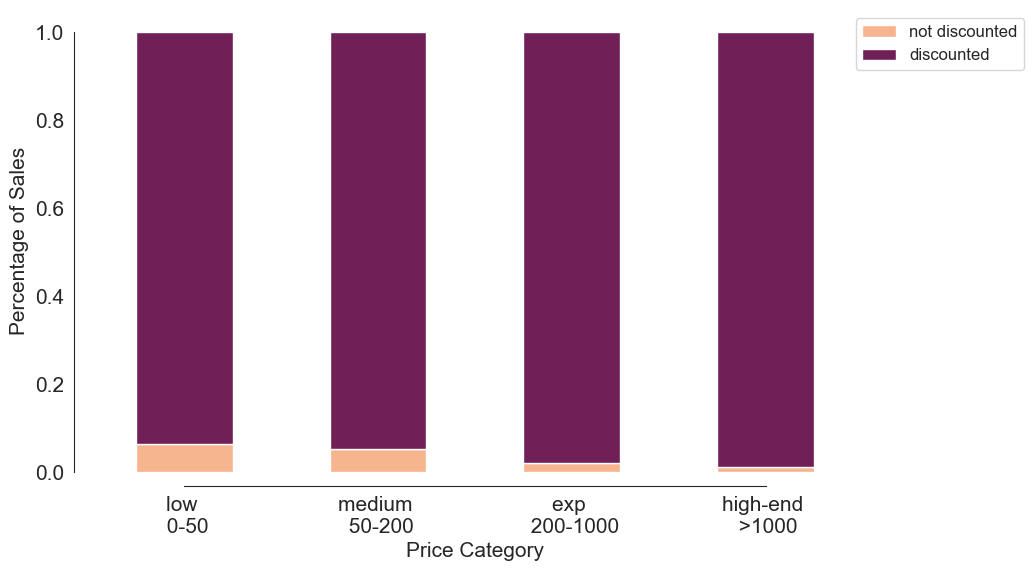

In [367]:
cross_tab.plot(kind='bar', stacked=True, color=[sns.color_palette("rocket")[5], sns.color_palette("rocket")[1]], figsize=(10,6))
sns.despine(offset=10, trim=True)
plt.xlabel("Price Category", fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Percentage of Sales", fontsize=15)
plt.xticks(range(len(new_x_labels)), new_x_labels, fontsize=15);
plt.legend(labels=legend_labels, fontsize=12, loc='upper center', bbox_to_anchor=(1.1, 1));